# Chapter 3


`Conteúudo originamente criado por Cam Davidson-Pilon`

`Transferido para Python 3 e PyMC3 por Max Margenot (@clean_utensils) e Thomas Wiecki (@twiecki) em Quantopian (@quantopian)`
____

Versão pt_BR

Tradução por Rodolpho Macedo dos Santos disponibilizado em [Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](http://github.com/rodolphomacedo/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)


## Abrindo a caixa preta do MCMC

Os dois capítulos anteriores esconderam do leitor a mecânica interna do PyMC3 e, mais geralmente, do Markov Chain Monte Carlo (MCMC). O motivo para incluir este capítulo é triplo. A primeira é que qualquer livro sobre inferência bayesiana deve discutir MCMC. Eu não posso lutar contra isso. Culpe os estatísticos. Em segundo lugar, conhecer o processo de MCMC dá uma ideia se o seu algoritmo convergiu. (Convergido para o quê? Chegaremos a isso) Em terceiro lugar, vamos entender *por que* recebemos milhares de amostras da posteriori como uma solução, o que à primeira vista pode ser estranho.

### A superfície Bayesiana

Quando construimos um problema de inferência Bayesiana com $N$ incógnitas, estamos criando implicitamente um espaço dimensional de tamanho $N$ para as distribuições posteriori existirem. Associado a esse espaço está uma dimensão adicional, que podemos descrever como a *superfície*, ou *curva*, que fica na parte superior do espaço, que reflete a *probabilidade a priori* de um determinado ponto. Essa superfície do espaço é definida por nossas distribuições a prioris. Por exemplo, se tivermos duas incógnitas $p_1$ e $p_2$, e as prioris de ambas forem $\text{Uniform}(0, 5)$, o espaço criado é um quadrado de comprimento 5 e a superfície é um plano plano que fica na parte superior desse quadrado (representando que cada ponto é igualmente provável).

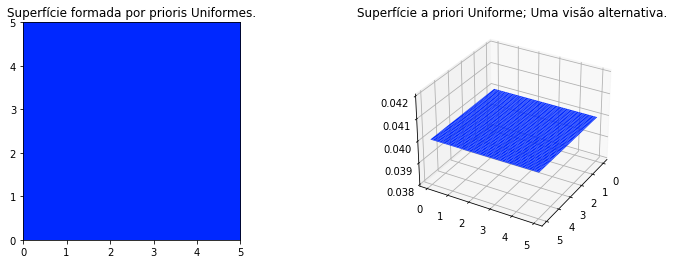

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície formada por prioris Uniformes.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Superfície a priori Uniforme; Uma visão alternativa.");

Alternativamente, se as duas prioris são $\text{Exp}(3)$ e $\text{Exp}(10)$, então o espaço contém todos números positivos no plano 2-D, e a superfície induzida pelas prioris parecem uma queda d'água que começa no ponto (0,0) e flui sobre os números positivos.

Os gráficos abaixo mostram isso. Quanto mais vermelho escuro for a cor, maior será a probabilidade a priori atribuída a esse ponto. Por outro lado, as áreas com azul mais escuro representam que nossas prioris atribuem probabilidade muito baixa para esses pontos.

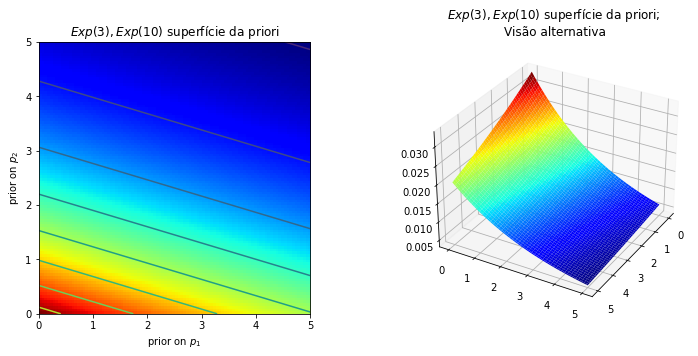

In [2]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
# M = exp_x[:, None] @ exp_y[None, :]  # Like to np.dot()
M = np.dot(exp_x[:, None], exp_y[None, :])

CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("prior on $p_1$")
plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ superfície da priori")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ superfície da priori; \nVisão alternativa");

Estes são exemplos simples no espaço 2D, onde nossos cérebros podem entender bem as superfícies. Na prática, os espaços e superfícies gerados por nossas prioris podem ser espaços dimensionais muito superiores.

Se essas superfícies descrevem nossas *distribuições a posteriori* nas incógnitas, o que acontece com nosso espaço depois que incorporamos nossos dados observados $X$? Os dados $X$ não mudam o espaço, mas mudam a superfície do espaço *puxando e esticando o tecido da superfície a priori* para refletir onde os verdadeiros parâmetros provavelmente residem. Mais dados significam mais puxões e esticões, e nossa forma original se torna multilada ou insignificante em comparação com a forma recém-formada. Com menos dados a nossa forma original estará mais presente. Independentemente disso, a superfície resultante descreve a *distribuição a posteriori*.



Mais uma vez devo enfatizar que é, infelizmente, impossível visualizar isso em grandes dimensões. Para duas dimensões, os dados essencialmente *empurram* a superfície original para formar *montanhas altas*. A tendência dos dados observados de *empurrar para cima* a probabilidade posteriori em certas áreas é verificada pela distribuição de probabilidade a priori, de modo que menos probabilidade a priori significa mais resistência. Assim, no caso anterior duplo-exponencial acima, uma montanha (ou várias montanhas) que poderia entrar em erupção perto do canto (0,0) seria muito mais alta do que montanhas que irromperiam mais perto de (5,5), uma vez que há mais resistência (baixa probabilidade a priori) próximo a (5,5). O pico reflete a probabilidade a posteriori de onde os verdadeiros parâmetros provavelmente serão encontrados. É importante ressaltar que se a priori atribuiu uma probabilidade de 0, nenhuma probabilidade posterior será atribuída lá.

Suponha que as prioris mencionadas acima representem diferentes parâmetros $\lambda$ de duas distribuições de Poisson. Observamos alguns pontos de dados e visualizamos a nova paisagem:

In [3]:
# criar os dados observados

# tamanho da amostra de dados que nós observamos, tente variar esse parâmetro (mantenha-o menor que 100;)
N = 1

# Esses são parâmetros verdadeiros, mas é claro que não conhecemos esses valores ...
lambda_1_true = 1
lambda_2_true = 3

# ... nós vemos os dados gerados, dependendo dos dois valores acima.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("Observando (bi-dimensional,tamanho da amostra = %d):" % N, data)

# Plotando os detalhes.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)

likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)

L = np.dot(likelihood_x[:, None], likelihood_y[None, :])


Observando (bi-dimensional,tamanho da amostra = 1): [[1 1]]


In [4]:
# Plot de como as curvas estão se comportanto em relação a todos os thetas - Descomentar função abaixo.
# Obs: essa parte não consta no livro original, por isso ficará comentado por padrão.
# Obs2: esses gráfico fazem mais sentido quando o N > 1

def plot_likelihood():
    figsize(12.5, 15)
    fig = plt.figure()
    
    plt.subplot(221)
    likelihood_by_function = [stats.poisson.pmf(data[:, 0], _x) for _x in x]
    plt.title('Likelihood - P(X|$ \\theta_x $)')
    plt.xlabel('$ \\theta_x $')
    plt.ylabel('Probabilidades')
    plt.plot(x, likelihood_by_function)
    plt.grid(ls='--')

    plt.subplot(223)
    plt.title('Likelihood \n Função de Verosimilhanças - (x)')
    plt.ylabel('Verosimilhanças')
    plt.grid(ls='--')
    plt.xlabel('$ \\theta_x $')
    plt.vlines(x=lambda_1_true, ymin=0, ymax=max(likelihood_x)/3, colors='r')
    plt.plot(x, likelihood_x)
    
    plt.subplot(222)
    likelihood_by_function = [stats.poisson.pmf(data[:, 1], _y) for _y in y]
    plt.title('Likelihood - P(X|$ \\theta_y $)')
    plt.xlabel('$ \\theta_y $')
    plt.ylabel('Probabilidades')
    plt.plot(x, likelihood_by_function)
    plt.grid(ls='--')
    
    plt.subplot(224)
    plt.title('Likelihood \n Função de Verosimilhanças - (y)')
    plt.ylabel('Verosimilhanças')
    plt.grid(ls='--')
    plt.xlabel('$ \\theta_y $')
    plt.vlines(x=lambda_2_true, ymin=0, ymax=max(likelihood_y)/3, colors='r')
    plt.plot(y, likelihood_y)
    
    plt.show()
    
# plot_likelihood()

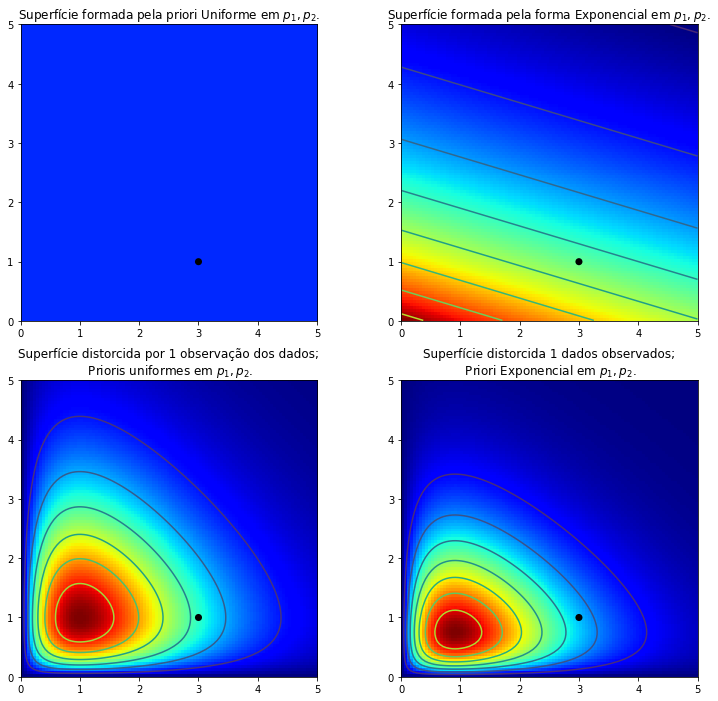

In [5]:
figsize(12.5, 12)
# rodar o matplotlib abaixo poderá ser pesado, cuidado!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])

im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície formada pela priori Uniforme em $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Superfície distorcida por %d observação dos dados;\n Prioris uniformes em $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Superfície formada pela forma Exponencial em $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Superfície distorcida %d dados observados;\n Priori Exponencial em \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


O gráfico à esquerda é a superfície deformada com as prioris $\text{Uniform}(0, 5)$, e o gráfico à direita é a superfície deformada com as prioris exponenciais. Observe que as superfícies a posteriori parecem diferentes umas das outras, embora os dados observados sejam idênticos em ambos os casos. A razão é a seguinte. Observe que a superfície a priori exponencial, figura inferior direita, atribui muito pouco peso *a posteriori* aos valores no canto superior direito da figura: isso ocorre porque *a priori não coloca muito peso ali*. Por outro lado, a superfície a priori uniforme fica feliz em colocar peso a posteriori no canto superior direito, assim como a priori coloca mais peso ali.

Observe também que o ponto mais alto, correspondendo ao vermelho mais escuro, está inclinado para (0,0) no caso exponencial, que é o resultado do exponencial a priori de colocar mais peso a priori no canto (0,0).


O ponto preto representa os verdadeiros parâmetros. Mesmo com 1 ponto de amostra, as montanhas tentam conter o parâmetro verdadeiro. É claro que a inferência com um tamanho de amostra 1 é incrivelmente ingênua, e escolher um tamanho de amostra tão pequeno foi apenas ilustrativo.

É um ótimo exercício tentar mudar o tamanho da amostra para outros valores (tentar 2, 5, 10, 100?...) e observar como a nossa "montanha" a posteriori mudará.

### Explorando a superfície usando MCMC

Devemos explorar o espaço a posteriori deformado que foi gerado por nossa superfície a priori e os dados observados para encontrar a montanha a posteriori. No entanto, não podemos ingenuamente pesquisar esse espaço: qualquer cientista da computação dirá que atravessar o espaço $N$-dimensional é exponencialmente difícil em $N$: o tamanho do espaço aumenta rapidamente à medida que aumentamos $N$ (veja [a maldição da dimensionalidade] (http://en.wikipedia.org/wiki/Curse_of_dimensionality)). Que esperança temos de encontrar essas montanhas escondidas? A ideia por trás do MCMC é realizar uma busca inteligente do espaço. Quando dizemos "busca" isso implica que estamos procurando um ponto específico, o que talvez não seja preciso, pois estamos realmente procurando uma montanha larga.

Lembre-se de que MCMC retorna *amostras* da distribuição a posteriori, e não a distribuição em si. Estendendo nossa analogia montanhosa ao seu limite, MCMC realiza uma tarefa semelhante a perguntar repetidamente "Qual a probabilidade de esta elevação que descobri ser da montanha que estou procurando?" E completa sua tarefa devolvendo milhares de elevações aceitas na esperança de reconstruir a montanha original. No jargão MCMC e PyMC3, a sequência retornada das "elevações" são as amostras, cumulativamente chamadas de *traces* (*traços, em português*).

Quando digo que o MCMC pesquisa de forma inteligente, estou realmente dizendo que o MCMC *esperançosamente* convergirá para as áreas de alta probabilidade da posteriori. MCMC faz isso explorando posições próximas e movendo-se para áreas com maior probabilidade. Novamente, talvez "convergir" não seja um termo preciso para descrever a progressão do MCMC. Convergência geralmente implica em mover-se em direção a um ponto no espaço, mas MCMC se move em direção a uma *área mais ampla* no espaço e anda aleatoriamente nessa área, pegando amostras daquela área.

#### Por que milhares de amostras?

A princípio, retornar milhares de samples ao usuário pode soar como uma forma ineficiente de descrever as distribuições a posterioris. Eu diria que isso é extremamente eficiente. Considere as possibilidades alternativas:

1. Retornar uma fórmula matemática para as "cadeias de montanhas" envolveria descrever uma superfície N-dimensional com picos e vales arbitrários.
2. Retornar o "pico" da superfície, embora matematicamente seja possível e também uma coisa sensata a se fazer, visto que o ponto mais alto corresponde à estimativa mais provável das incógnitas, ignorariamos a forma da superfície, que argumentamos anteriormente ser muito importante para determinar confiança a posteriori em locais desconhecidos desconhecidos.

Além das razões computacionais, provavelmente a razão mais forte para retornar amostras é que podemos facilmente usar a *Lei dos Números Grandes* para resolver problemas que de outra forma seriam intratáveis. Adiamento esta discussão para o próximo capítulo. Com as milhares de amostras, podemos reconstruir a superfície a posteriori, organizando-as em um histograma.

### Algoritmos para realizar MCMC

Existe uma grande família de algoritmos que executam MCMC. A maioria desses algoritmos pode ser expressa em alto nível da seguinte forma: (Detalhes matemáticos podem ser encontrados no apêndice.)

1. Comece na posição atual.
2. Proponha a mudança para uma nova posição (investigue uma elevação perto de você).
3. Aceite / Rejeite a nova posição com base na aderência da posição aos dados e distribuições a priori (pergunte se a elevação provavelmente veio da montanha).
4. 1. Se você aceitar: Mova para a nova posição. Volte para a Etapa 1.
   2. Caso contrário: Não mova para a nova posição. Volte para a Etapa 1.
5. Após um grande número de iterações, retorne todas as posições aceitas.

Desta forma, nos movemos na direção geral em para às regiões onde existem as distribuições a posteriori, e coletamos amostras com moderação durante essa viagem. Assim que alcançarmos a distribuição a posteriori, podemos facilmente coletar amostras, pois provavelmente todas pertencem à distribuição posterior.

Se a posição atual do algoritmo MCMC estiver em uma área de probabilidade extremamente baixa, o que geralmente é o caso quando o algoritmo começa (normalmente em um local aleatório no espaço), o algoritmo se moverá em direções *que provavelmente não são da posteriori*, mas estará fazendo o melhor que puder nessas proximidades. Assim, os primeiros movimentos do algoritmo não refletem a posteriori.

No pseudocódigo do algoritmo acima, observe que apenas a posição atual importa (as novas posições são investigadas apenas quando perto da posição atual). Podemos descrever essa propriedade como *falta de memória*, ou seja, o algoritmo não se importa *como* ele chegou à sua posição atual, apenas que está lá.

### Outras soluções de aproximação para a posteriori
Além do MCMC, existem outros procedimentos disponíveis para determinar as distribuições posteriores. Uma aproximação de Laplace é uma aproximação da posterior usando funções simples. Um método mais avançado é [Variational Bayes] (http://en.wikipedia.org/wiki/Variational_Bayesian_methods). Todos os três métodos, aproximações de Laplace, Bayes variacionais e MCMC clássico têm seus prós e contras. Iremos nos concentrar apenas no MCMC neste livro. Dito isso, meu amigo Imri Sofar gosta de classificar algoritmos MCMC como "eles são uma merda" ou "eles realmente são uma merda". Ele classifica o sabor particular de MCMC usado por PyMC3 como apenas *péssimo*;)

##### Exemplo: Clustering não supervisionado usando um modelo de mistura

Suponha que recebamos o seguinte conjunto de dados:

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


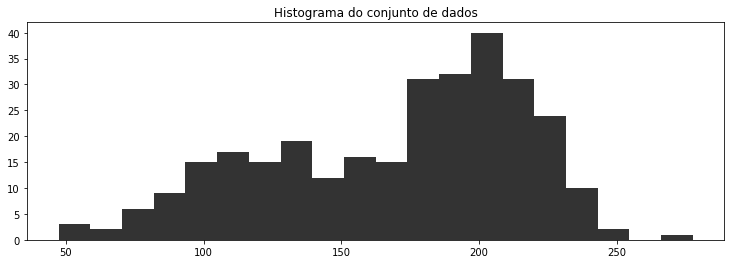

In [6]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histograma do conjunto de dados")
plt.ylim([0, None]);
print(data[:10], "...")


O que os dados sugerem? Parece que os dados têm uma forma bimodal, ou seja, parecem ter dois picos, um próximo a 120 e outro próximo a 200. Talvez haja *dois clusters* neste conjunto de dados.

Este conjunto de dados é um bom exemplo da técnica de modelagem de geração de dados do capítulo anterior. Podemos propor *como* os dados podem ter sido criados. Eu sugiro o seguinte algoritmo de geração de dados:

1. Para cada ponto, escolha o cluster 1 com probabilidade $p$, caso contrário, escolha o cluster 2.
2. Desenhe uma variável aleatória de uma distribuição normal com os parâmetros $\mu_i$ e $\sigma_i$, no qual onde $i$ foi escolhido na etapa anterior.
3. Repita.

Este algoritmo criará um efeito semelhante ao conjunto de dados observado, portanto, escolhemos isso como nosso modelo. Claro, não conhecemos $p$ ou os parâmetros das distribuições normais. Portanto, devemos inferir, ou *aprender*, esses parâmetros.

Denote as distribuições normais $\text{N}_0$ e $\text{N}_1$ (ter o índice das variáveis começando em 0 é apenas Pythônico). Ambos têm atualmente média e desvio padrão desconhecidos, denotados $\mu_i$ e $\sigma_i, \; i=0, 1$ respectivamente. Um ponto específico pode ser amostrado da $\text{N}_0$ ou $\text{N}_1$, e assumimos que o ponto é sorteado da $\text{N}_0$ com probabilidade $p$.

Uma maneira apropriada de atribuir os pontos a clusters é usar uma variável estocástica do PyMC3 `Categorical`. Seu parâmetro é um array de probabilidades (nesse caso, `p`) de comprimento $k$ que deve somar $1$ e seu atributo `value` é um número inteiro entre $0$ e $k-1$ escolhido aleatoriamente de acordo com o array de probabilidades criado (no nosso caso $k = 2$). *A priori*, não sabemos qual é a probabilidade que atribuiremos ao cluster 1, então construímos uma variável uniforme em $Uniform(0, 1)$. Chamamos ela de $p_1$, então a probabilidade de pertencer ao cluster 2 é, portanto, $p_2 = 1 - p_1$.

Infelizmente, não podemos simplesmente passar `[p1, p2]` à nossa variável `Categorical`. pois o PyMC3 usa Theano sob o capô para construir os modelos, então precisamos usar `theano.tensor.stack ()` para combinar $p_1$ e $p_2$ em um vetor que ele possa entender. Passamos esse novo vetor para a variável `Categorical`, bem como o parâmetro` testval` para dar à nossa variável uma ideia de por onde começar.

In [7]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("Atribuição à priori, com p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:35])

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Atribuição à priori, com p = 0.50:
[0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0]


Olhando para o conjunto de dados acima, acho que os desvio padrões das duas normais são diferentes. Para manter a ignorância de quais podem ser os desvios padrões das normais, iremos inicialmente modelá-los como uniformes de $0$ a $100$. Incluiremos ambos os desvios padrões em nosso modelo usando uma única linha de código PyMC3:

    sds = pm.Uniform("sds", 0, 100, shape=2)

Observe que especificamos `shape = 2`: assim estaremos modelando os $\sigma$s como uma única variável no PyMC3. Observe que isso não induz uma necessária relação entre os dois $\sigma$s, simplesmente escrevemos assim para ser sucinto.


Também precisamos especificar nas prioris os centros dos clusters. Os centros são realmente os parâmetros $\mu$ das distribuições normais. Suas prioris podem ser modeladas por uma distribuição normal. Olhando para os dados, tenho uma ideia de onde os dois centros podem ser estimados; Eu acho que algo em torno de $120$ e $190$ respectivamente, embora não esteja muito confiante nessas estimativas feitas a olho nu. Portanto, irei definir $\mu_0 = 120, \mu_1 = 190$ e $\sigma_0 = \sigma_1 = 10$.

In [8]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers",
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # e combiná-los ela com as observações da amostra:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Atribuições aleatórias: \t", assignment.tag.test_value[:10], "...")
print("Atribuições do centro: \t\t", center_i.tag.test_value[:10], "...")
print("Atribuições do desvio padrão: \t", sd_i.tag.test_value[:10])

Atribuições aleatórias: 	 [0 1 1 1 0 0 0 0 0 1] ...
Atribuições do centro: 		 [120. 190. 190. 190. 120. 120. 120. 120. 120. 190.] ...
Atribuições do desvio padrão: 	 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]


Observe como continuamos a construir o modelo dentro do contexto de `Model()`. Isso adiciona automaticamente as variáveis que criamos ao nosso modelo (*model*). Enquanto trabalharmos dentro deste contexto, estaremos trabalhando com as mesmas variáveis que já definimos.

Da mesma forma, qualquer amostragem que fizermos no contexto de `Model()` será feita apenas no modelo em cujo contexto estamos trabalhando. Diremos ao nosso modelo para explorar o espaço que definimos até agora definindo os métodos de amostragem, neste caso `Metropolis()` para nossas variáveis contínuas e `ElemwiseCategorical()` para nossa variável categórica. Usaremos esses métodos de amostragem juntos para explorar o espaço usando `sample(iteractions, step)`, onde `iteractions` é o número de passos que você deseja que o algoritmo execute e `step` é a maneira como você deseja manipular essas etapas. Usamos nossa combinação de `Metropolis()` e `ElemwiseCategorical()` $^1$ para a `step` e amostra (sample) de $25.000$ `iteractions` abaixo.

----
$^1\mbox{(Nota do Tradutor): }$ A versão original usa `ElemwiseCategorical()`, no momento da tradução, a função está depreciada: 

*DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.*

Utilizaremos a função `CategoricalGibbsMetropolis` em seu lugar.

In [9]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    # step2 = pm.ElemwiseCategorical(vars=[assignment])  # DeprecationWarning
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 4 chains, 0 divergences: 100%|██████████| 102000/102000 [16:52<00:00, 100.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


Armazenamos os caminhos de todas as nossas variáveis, ou "traces", na variável `trace`. Esses caminhos são as rotas dos parâmetros desconhecidos ($centers$, $sds$ e $p$) seguiram até o momento. O caminho individual de cada variável é indexado pela variável PyMC3 `name` que demos a essa variável ao defini-la em nosso modelo. Por exemplo, `trace["sds"]` retornará um objeto `numpy.array` que podemos indexar e fatiar como faríamos com qualquer outro objeto` numpy.array`.

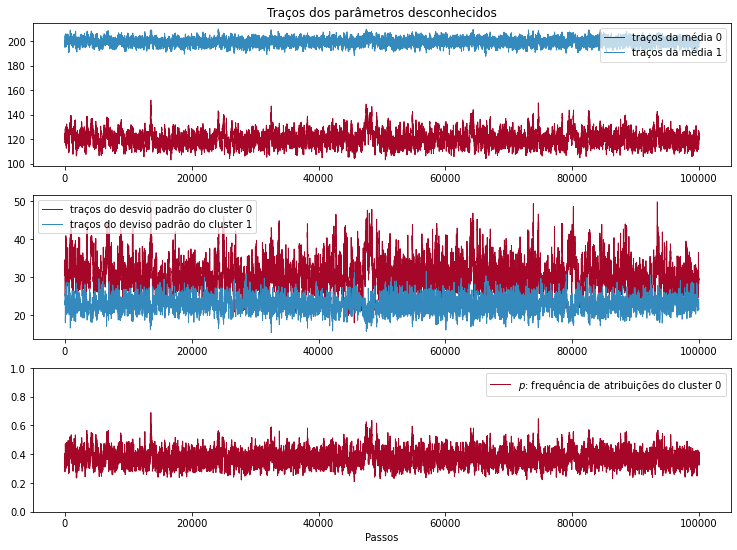

In [10]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# para cores bonitas mais tarde no livro.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="traços da média 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="traços da média 1", c=colors[1], lw=lw)
plt.title("Traços dos parâmetros desconhecidos")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="traços do desvio padrão do cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="traços do deviso padrão do cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequência de atribuições do cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Passos")
plt.ylim(0, 1)
plt.legend();


Observe as seguintes características:

1. Os traços convergem, não para um único ponto, mas para uma *distribuição* de pontos possíveis. Isso é *convergência* em um algoritmo MCMC.
2. Na inferência, usar os primeiros milhares de pontos é uma má ideia, pois eles não estão relacionados com a distribuição final na qual estamos interessados. Portanto, é uma boa ideia descartar essas amostras antes de usar as amostras para inferência. Chamamos esse período antes da convergência de *período de burn-in $^1$*.
3. Os traços aparecem como um "passeio" aleatório pelo espaço, ou seja, os caminhos apresentam correlações com as posições anteriores. Isso é bom e ruim. Sempre teremos correlações entre as posições atuais e as anteriores, mas muito disso significa que não estamos explorando bem o espaço. Isso será detalhado na seção Diagnósticos posteriormente, ainda neste capítulo.


Para alcançar maior convergência, realizaremos mais etapas MCMC. No algoritmo de pseudo-código do MCMC acima, a única posição que importa é a posição atual (novas posições são investigadas perto da posição atual), armazenada implicitamente como parte do objeto `trace`. Para continuar de onde paramos, passamos o `trace` que já armazenamos na função `sample()` com o mesmo valor de passo. Os valores que já calculamos não serão substituídos. Isso garante que nossa amostragem continue de onde parou da mesma forma que parou.

Vamos experimentar o MCMC mais cinquenta mil vezes e visualizar o progresso abaixo:

----
$^1 \mbox{(Nota do Tradutor): }$ *Período de burn-in* (período de queima), pode ser entendido como período inicial que será descartado.

In [11]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 4 chains, 0 divergences: 100%|██████████| 202000/202000 [35:11<00:00, 95.66draws/s] 
The number of effective samples is smaller than 10% for some parameters.


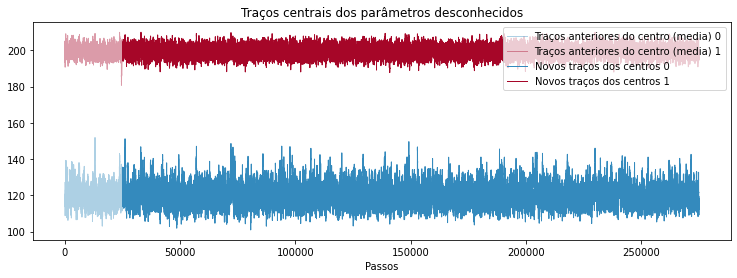

In [12]:
figsize(12.5, 4)
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="Traços anteriores do centro (media) 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="Traços anteriores do centro (media) 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 275000)
plt.plot(x, center_trace[25000: 275000, 0], label="Novos traços dos centros 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[25000: 275000, 1], label="Novos traços dos centros 1", lw=lw, c="#A60628")

plt.title("Traços centrais dos parâmetros desconhecidos")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Passos");


####  Investigação dos Cluster

Não esquecemos o nosso principal desafio: identificar os clusters. Determinamos distribuições a posteriori para nossos desconhecidos. Plotamos as distribuições a posteriori das variáveis de centro (média) e desvio padrão abaixo:

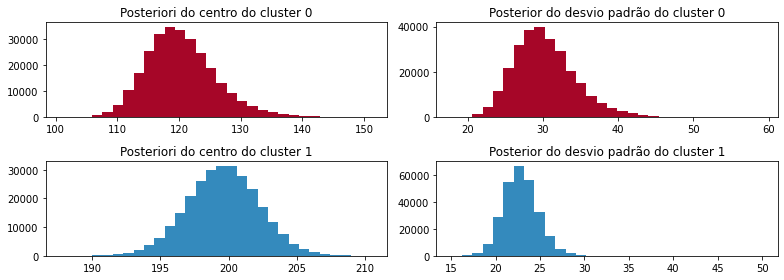

In [13]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posteriori do centro do cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior do desvio padrão do cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

O algoritmo MCMC propôs que os centros mais prováveis dos dois clusters estão próximos a 120 e 200, respectivamente. Inferências semelhantes podem ser aplicadas ao desvio padrão.


Também recebemos as distribuições a posteriori para os rótulos do ponto, que está presente em `trace ["assignment"]`. Abaixo está uma visualização disso. O eixo y representa uma sub-amostra dos rótulos posteriores para cada ponto de dados. No eixo x estão os valores dos pontos classificados. Um quadrado vermelho é uma atribuição para o cluster 0 e um quadrado azul é uma atribuição para o cluster 1.

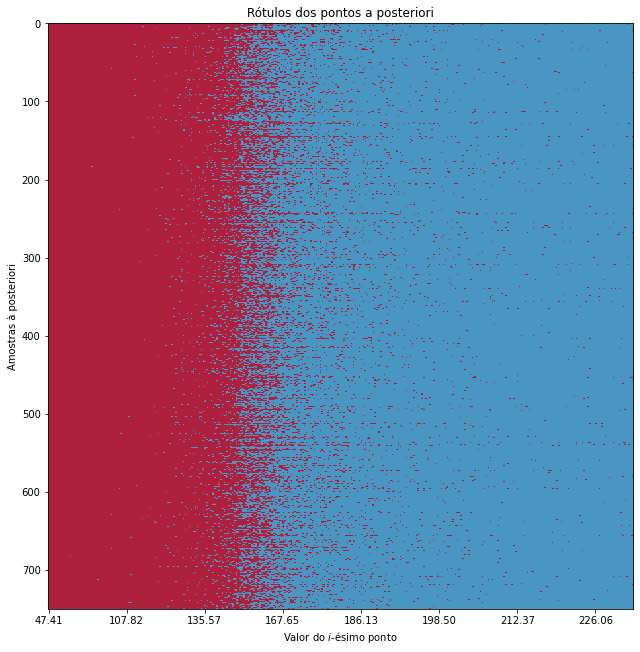

In [14]:
import matplotlib as mpl
figsize(10.5, 12.5)

plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)

plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("Amostras à posteriori")
plt.xlabel("Valor do $i$-ésimo ponto")
plt.title("Rótulos dos pontos a posteriori");

Olhando para o gráfico acima, parece que a maior incerteza está entre 150 e 170. O gráfico acima representa um pouco mal as coisas, já que o eixo x não é uma escala verdadeira (ele exibe o valor do *i*-ésimo ponto classificado.) Um diagrama mais claro está abaixo, onde estimamos a *frequência* de cada ponto pertencente aos rótulos 0 e 1.

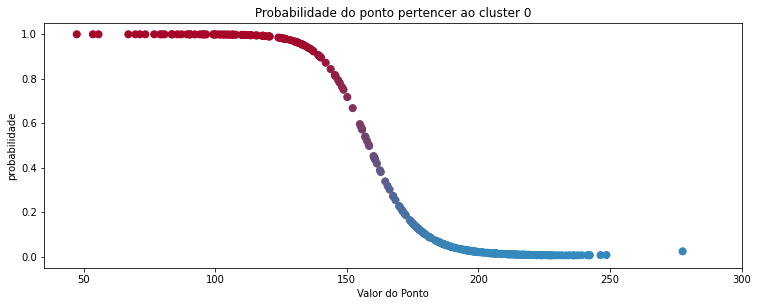

In [15]:
figsize(12.5, 4.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probabilidade do ponto pertencer ao cluster 0")
plt.ylabel("probabilidade")
plt.xlabel("Valor do Ponto");


Embora tenhamos modelado os clusters usando distribuições Normal, não obtivemos apenas uma única distribuição Normal que *melhor* se ajusta aos dados (seja qual for nossa definição de melhor), mas uma distribuição de valores para os parâmetros da Normal. Como podemos escolher apenas um único par de valores para a média e variância e determinar uma gaussiana que tenha *meio que o melhor ajuste*?

Uma maneira rápida e suja (que tem boas propriedades teóricas que veremos no Capítulo 5) é usar a *média* das distribuições à posterioris. Abaixo, sobrepomos as funções de densidade normal, usando a média das distribuições posteriores como os parâmetros escolhidos, com nossos dados observados:

In [16]:
center_trace[0:10,0:10].mean(axis=0)

array([121.78068163, 200.07975499])

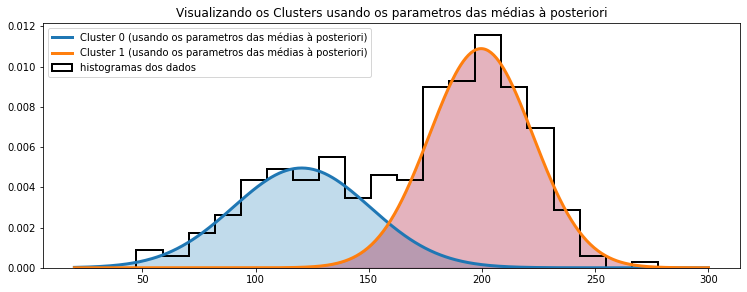

In [17]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",  # *
     lw=2, label="histogramas dos dados")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (usando os parametros das médias à posteriori)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (usando os parametros das médias à posteriori)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizando os Clusters usando os parametros das médias à posteriori");


----
(*) Nota do Tradutor: Na função abaixo, o argumento normed está depreciado.

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogramas dos dados")

*Deprecated; use the density keyword argument instead.*


### Importante: Não misture amostras posteriores

No exemplo acima, um cenário possível (embora menos provável) é que o cluster 0 tem um desvio padrão muito grande e o cluster 1 tem um pequeno desvio padrão. Isso ainda corroboraria com as evidências, embora menos do que nossa inferência original. Alternativamente, isto seria incrivelmente improvável que *ambas* as distribuições tivessem um pequeno desvio padrão, já que os dados não apóiam essa hipótese. Assim, os dois desvios padrão são *dependentes* um do outro: se um for pequeno, o outro deve ser grande. Na verdade, *todas* as incógnitas estão relacionadas de maneira semelhante. Por exemplo, se um desvio padrão for grande, a média terá um espaço possível mais amplo de realizações. Por outro lado, um pequeno desvio padrão restringe a média a uma pequena área.


Durante o MCMC, retornamos os vetores que representam amostras das distribuições à posteriori desconhecidas. Os elementos dos vetores diferentes não podem ser usados juntos, pois isso quebraria a lógica acima: talvez uma amostra tenha retornado que o cluster 1 tem um pequeno desvio padrão, portanto, todas as outras variáveis nessa amostra incorporariam isso e seriam ajustadas de acordo. No entanto, é fácil evitar esse problema, apenas certifique-se de estar indexando os rastreamentos corretamente.

Outro pequeno exemplo para ilustrar o ponto. Suponha que duas variáveis, $x$ e $y$, estejam relacionadas por $x + y = 10$. Modelamos $x$ como uma variável aleatória normal com média 4 e investigamos 500 amostras.

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:04<00:00, 8930.47draws/s] 
The number of effective samples is smaller than 25% for some parameters.


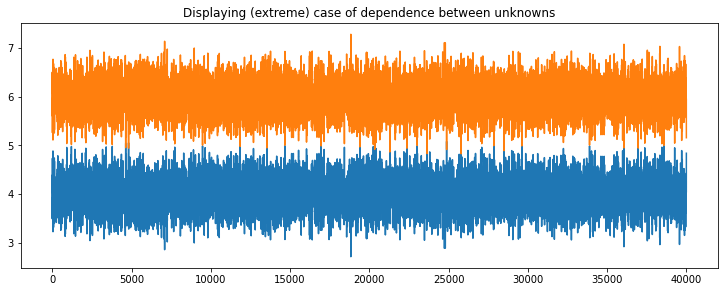

In [18]:
import pymc3 as pm

with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");


Como você pode ver, as duas variáveis não são independentes, e seria errado adicionar a $i$-ésima amostra de $x$ à $j$-ésima amostra de $y$, a menos que $i = j$.

#### Retornando ao Clustering: Predição
O cluster acima pode ser generalizado para $k$ clusters. A escolha de $k = 2$ nos permitiu visualizar melhor o MCMC e examinar alguns gráficos muito interessantes.

E a previsão? Suponha que observemos um novo ponto de dados, digamos $x = 175$, e desejemos rotulá-lo como um cluster. É tolice simplesmente atribuí-lo ao centro do cluster *mais próximo*, pois isso ignora o desvio padrão dos clusters, e vimos nos gráficos acima que essa consideração é muito importante. Mais formalmente: estamos interessados na *probabilidade* (já que não podemos ter certeza sobre os rótulos) de atribuir $x = 175$ ao cluster 1. Denote a atribuição de $x$ como $L_x$, que é igual a 0 ou 1 , e estamos interessados em $P(L_x = 1 \;|\; x = 175)$.

Um método ingênuo para calcular isso é executar novamente o MCMC acima com o ponto adicional anexado. A desvantagem desse método é que sua inferência será lenta para cada novo ponto de dados. Como alternativa, podemos tentar um método *menos preciso*, mas muito mais rápido.

Usaremos o Teorema de Bayes para isso. Se você se lembra, o Teorema de Bayes se parece com:


$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

No nosso caso, o $A$ representa $L_x = 1$ e $X$ é a evidência que temos: observamos que $x = 175$. Para um determinado conjunto de parâmetros de amostra para nossa distribuição posterior, $(\ mu_0, \ sigma_0, \ mu_1, \ sigma_1, p)$, estamos interessados em perguntar "A probabilidade de $x$ estar no cluster 1  é *maior* do que a probabilidade de está no cluster 0?", onde a probabilidade é dependente dos parâmetros escolhidos.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

Como os denominadores são iguais, eles podem ser ignorados (e boa viagem, porque calcular a quantidade $P (x = 175)$ pode ser difícil).


$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$







In [19]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probabilidade de pertencer ao cluster 1:", v.mean())


Probabilidade de pertencer ao cluster 1: 0.009185454545454545


É muito útil nos dar uma probabilidade em vez de um rótulo. 
Em vez do ingênuo

    L = 1 if prob > 0.5 else 0

podemos otimizar nossas suposições usando uma *função de perda*, no qual o quinto capítulo é totalmente dedicado a isso.

### Usando `MAP` para melhorar a convergência

Se você executou o exemplo acima sozinho, deve ter notado que nossos resultados não foram consistentes: talvez sua divisão dos clusters fosse mais dispersa, ou talvez menos dispersa. O problema é que nossos traços são uma função dos *valores iniciais* do algoritmo MCMC.

Pode ser matematicamente mostrado que, deixando o MCMC funcionar por tempo suficiente, ao realizar muitos passos, o algoritmo *deve esquecer sua posição inicial*. Na verdade, é isso que significa dizer que o MCMC convergiu (na prática, embora nunca possamos alcançar a convergência total). Portanto, se observarmos análises posteriores diferentes, é provável que nosso MCMC ainda não tenha convergido totalmente e não devemos usar amostras dele ainda (devemos usar um período de burn-in maior).

Na verdade, se valores iniciais são pobres eles podem impedir qualquer convergência ou retardá-la significativamente. Idealmente, gostaríamos que a cadeia começasse no *pico* de nossa superfície, pois é exatamente onde existem as distribuições à posteriori. Portanto, se começarmos no "pico", poderemos evitar um longo período de burn-in e inferência incorreta. Geralmente, chamamos este "pico" de *máximo a posterior* ou, mais simplesmente, de *MAP*.

Claro, nós não sabemos onde está o MAP. PyMC3 fornece uma função que irá aproximar, se não encontrar, a localização do MAP. No namespace principal do PyMC3 está a função `find_MAP`. Se você chamar esta função dentro do contexto de `Model()`, ela irá calcular o MAP que você pode então passar para `pm.sample()` como um parâmetro `start`.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

A função `find_MAP()` tem a flexibilidade de permitir ao usuário escolher qual algoritmo de otimização usar (afinal, este é um problema de otimização: estamos procurando os valores que maximizam nossa superfície), já que nem todos os algoritmos de otimização são criados iguais. O algoritmo de otimização padrão na chamada de função é o algoritmo Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) para encontrar o máximo do log-posteriori. Como alternativa, você pode usar outros algoritmos de otimização do módulo `scipy.optimize`. Por exemplo, você pode usar o método de Powell, um dos favoritos do blogueiro [Abraham Flaxman](http://healthyalgorithms.com/) [1], o PyMC faz a chamada `find_MAP (fmin = scipy.optimize.fmin_powell)`. O padrão funciona bem o suficiente, mas se a convergência for lenta ou não garantida, sinta-se à vontade para experimentar o método de Powell ou os outros algoritmos disponíveis.

O MAP também pode ser usado como uma solução para o problema de inferência, visto que, matematicamente, é o valor *mais provável* para as incógnitas. Mas, conforme mencionado anteriormente neste capítulo, esse local ignora a incerteza e não retorna uma distribuição.

#### Falando do período de burn-in

Ainda é uma boa idéia decidir sobre qual o período de burn-in, mesmo se estivermos usando `find_MAP()` antes da amostragem, apenas por segurança. Não podemos mais descartar a amostra automaticamente com um parâmetro `burn` na função `sample()` como poderíamos em PyMC2, mas é fácil o suficiente simplesmente descartar a seção inicial do traço apenas através do corte da matriz. Como não se sabe quando a cadeia convergiu totalmente, uma boa regra prática é descartar a primeira *metade* de suas amostras, às vezes até 90% das amostras para execuções mais longas. Para continuar o exemplo de clustering acima, o novo código seria semelhante a:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, start=start)
    
    burned_trace = trace[50000:]


## Diagnosticando a Convergência

### Autocorrelação

A autocorrelação é uma medida de quão relacionada uma série de números está consigo mesma. Uma medida de 1.0 é autocorrelação positiva perfeita, já 0.0 não existe autocorrelação e, por fim, -1.0 é correlação negativa perfeita. Se você estiver familiarizado com a *correlação* padrão, então a autocorrelação é exatamente o quão correlacionada uma série, $x_t$ no momento $t$ está com a série no momento $t_k$

$$R(k) = Corr( x_t, x_{t-k} )$$

Por exemplo, considere as duas séries abaixo:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$


que têm caminhos de exemplo tais como:

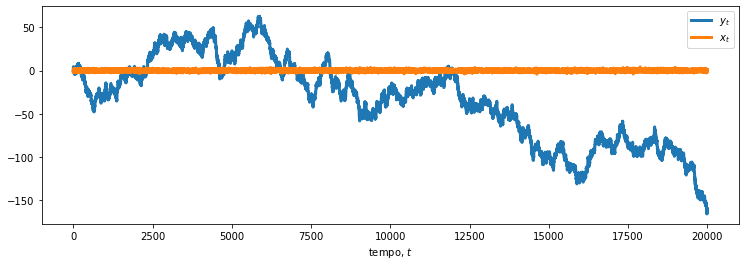

In [41]:
figsize(12.5, 4)

import pymc3 as pm

x_t = np.random.normal(0, 1, 20000)
x_t[0] = 0
y_t = np.zeros(20000)

for i in range(1, 20000):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("tempo, $t$")

plt.legend();

Uma maneira de pensar em autocorrelação é "Se eu souber a posição da série no tempo $s$, isso pode me ajudar a saber onde estarei no tempo $t$?" Na série $x_t$, a resposta é Não. Por construção, $x_t$ são variáveis aleatórias. Se eu dissesse que $x_2 = 0.5$, você poderia me dar um palpite melhor sobre $x_3$? Não.

Por outro lado, $y_t$ é autocorrelacionado. Por construção, se eu soubesse que $y_2 = 10$, posso ter certeza de que $ y_3 $ não estará muito longe de 10. Da mesma forma, posso até fazer um (palpite menos confiante) sobre $y_4$: provavelmente não seja próximo de 0 ou 20, mas um valor de 5 é mais provável ocorrer. Posso construir um argumento semelhante sobre $y_5$, mas, novamente, estou menos confiante. Levando isso à sua conclusão lógica, devemos admitir que à medida que $k$, que é a defasagem entre os tempo aumenta, a autocorrelação diminui. Podemos visualizar isso abaixo:

In [42]:
len(autocorr(x_t))

20000

In [37]:
len(x)

20000

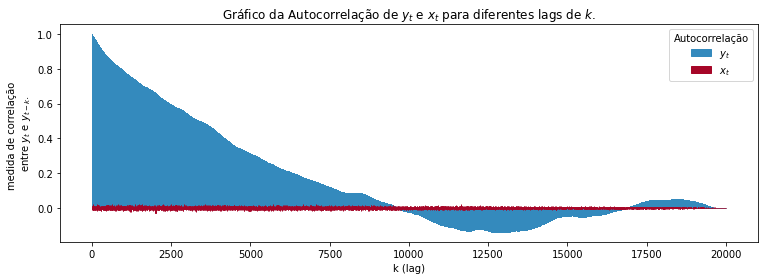

In [43]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 20000)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelação")
plt.ylabel("medida de correlação \nentre $y_t$ e $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Gráfico da Autocorrelação de $y_t$ e $x_t$ para diferentes lags de $k$.");

Observe que à medida que $k$ aumenta, a autocorrelação de $y_t$ diminui a partir de um ponto muito alto. Compare com a autocorrelação de $x_t$ que se parece com ruído (o que realmente é), portanto, podemos concluir que não existe autocorrelação nesta série.


#### Como isso se relaciona com a convergência MCMC?

Pela natureza do algoritmo MCMC, sempre receberemos amostras que exibem autocorrelação (isso é devido ao passo `partindo de sua posição atual, move-se para uma posição próxima a de partida`).

Uma cadeia que não está explorando bem o espaço exibirá uma autocorrelação muito alta. Visualmente, se o traço parecer serpentear como um rio, e não se estabelecer, a corrente terá alta autocorrelação.

Isso não significa que um MCMC convergido tenha baixa autocorrelação. Portanto, baixa autocorrelação não é necessária para a convergência, mas é suficiente. PyMC3 tem uma função de plotagem de autocorrelação embutida no módulo `plots`.

### Desbaste

Outro problema que pode surgir é se houver alta autocorrelação entre as amostras à posterioris. Muitos algoritmos de pós-processamento exigem que as amostras sejam *independentes* umas das outras. Isso pode ser resolvido, ou pelo menos reduzido, retornando ao usuário apenas a cada $n$-ésima amostra, removendo, assim, alguma autocorrelação. Abaixo, realizamos um gráfico de autocorrelação para $y_t$ com diferentes níveis de desbaste:

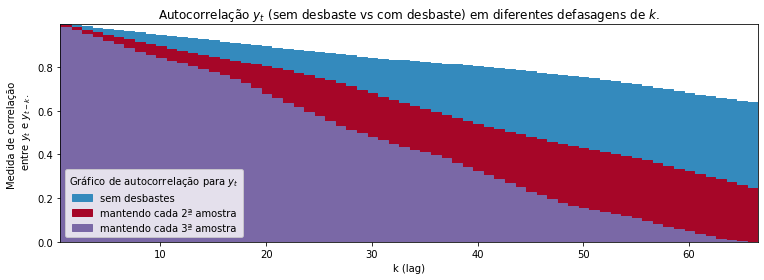

In [22]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="sem desbastes", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="mantendo cada 2ª amostra", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="mantendo cada 3ª amostra", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Gráfico de autocorrelação para $y_t$", loc="lower left")
plt.ylabel("Medida de correlação \n entre $y_t$ e $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelação $y_t$ (sem desbaste vs com desbaste) \
em diferentes defasagens de $k$.");


Com mais desbaste, a autocorrelação cai mais rápido. Porém, há uma desvantagem: o desbaste mais alto requer mais iterações MCMC para atingir o mesmo número de amostras retornadas. Por exemplo, 10.000 amostras não diluídas são 100.000 com um desbaste de 10 (embora a última tenha menos autocorrelação).

Mas então, o que é uma boa quantidade de desbaste? As amostras retornadas sempre exibirão alguma autocorrelação, independente de quanto desbaste seja feito. Contanto que a autocorrelação tenda a zero, provavelmente você está bem. Normalmente, não é necessário diluir mais de 10.

### `pymc3.plots`

Parece bobagem ter que criar histogramas manualmente, gráficos de autocorrelação e gráficos dos traços cada vez que executamos o MCMC. Os autores do PyMC3 incluíram uma ferramenta de visualização exatamente para esse propósito.

O módulo `pymc3.plots` contém algumas funções de plotagem diferentes que podem ser úteis. Para cada função de plotagem diferentes contida nela, você simplesmente passa um `trace` retornado da amostragem, bem como uma lista,`varnames`, das variáveis de seu interesse. Este módulo pode fornecer gráficos de autocorrelação e as distribuições posteriores de cada variável e seus traços, e entre outras informações.

Abaixo usamos a ferramenta para plotar os centros dos clusters.

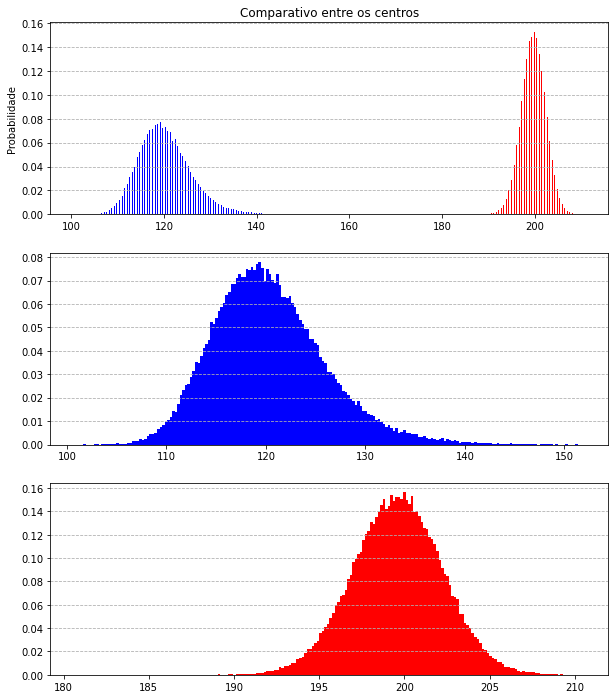

In [116]:
fig, ax = plt.subplots(3, figsize=(10, 12))


ax[0].hist(trace['centers'], bins=200, density=True, color=['b', 'r'])
ax[0].grid(axis='y', ls='--')
ax[0].set_title("Comparativo entre os Centros")
ax[0].set_ylabel("Probabilidade")


ax[1].hist(trace['centers'][:, 0], density=True, bins=200, color='b')
ax[1].grid(axis='y', ls='--')
ax[0].set_title("Comparativo entre os centros")
ax[0].set_ylabel("Probabilidade")

ax[2].hist(trace['centers'][:, 1], density=True, bins=200, color='r')
ax[2].grid(axis='y', ls='--')

# TODO: Need to adjust this part.
# See the original graph in: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb 
# ax[3].acorr(trace['centers'][:, 0], usevlines=True, maxlags=50, normed=True, lw=2)

plt.show()

A primeira função de plotagem nos dá a densidade posteriori de cada variável desconhecida `centers`, bem como o `trace` de cada uma. O gráfico `trace` é útil para inspecionar aquela possível propriedade "sinuosa" que é um resultado da não convergência. O gráfico da densidade nos dá uma ideia da forma de cada distribuição desconhecida, mas é melhor olhar para cada uma delas individualmente.

A(s) segunda(s) função(ões) de plotagem nos fornece um histograma das amostras com alguns recursos adicionais.O texto sobreposto no centro nos mostra a média à posteriori, que é um bom resumo da distribuição à posteriori. O intervalo marcado pela linha preta horizontal sobreposta representa o *intervalo de credibilidade de 95%*, às vezes chamado de *intervalo de densidade à posteriori mais alto* e não deve ser confundido com um *intervalo de confiança de 95%*. Não entraremos no último, mas o primeiro pode ser interpretado como "há 95% de probabilidade de o parâmetro de interesse estar neste intervalo". Ao comunicar seus resultados a outras pessoas, é extremamente importante declarar esse intervalo. Um dos nossos objetivos para estudar os métodos bayesianos é ter uma compreensão clara de nossa incerteza nas incógnitas. Combinado com a média à posteriori, o intervalo de credibilidade de 95% fornece um intervalo confiável para comunicar a localização mais provável da variável desconhecida (fornecida pela média) *e* a incerteza (representada pela largura do intervalo).

Os últimos gráficos, intitulados `center_0` e `center_1` são os gráficos de autocorrelação gerados, semelhantes aos exibidos acima.$^1$

---

**Nota do Tradutor**: $^1$ *O quarto gráfico, autocorrelação deverá ser revisado, pois a função acorr do matplotlib está apresentando valores estranhos.*

Veja o gráfico original em (*no final da página*):
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

## Dicas úteis para MCMC

A inferência bayesiana seria o método *de fato* se não fosse pelas dificuldades computacionais do MCMC. Na verdade, MCMC é o que desativa a maioria dos usuários da inferência Bayesiana prática. A seguir, apresento algumas boas heurísticas para ajudar na convergência e acelerar o mecanismo MCMC:


### Intelligent starting values

Seria ótimo iniciar o algoritmo MCMC próximo à distribuição à posteriori, de modo que levará pouco tempo para iniciar a amostragem corretamente. Podemos ajudar o algoritmo dizendo onde *pensamos* que a distribuição à posterior estará, especificando o parâmetro `testval` na criação da variável `Estocástico`. Em muitos casos, podemos produzir uma estimativa razoável para o parâmetro. Por exemplo, se tivermos dados de uma distribuição normal e desejarmos estimar o parâmetro $\mu$, um bom valor inicial seria a *média* dos dados.

     mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )


Para a maioria dos parâmetros nos modelos, há uma estimativa frequencista dele. Essas estimativas são um bom valor inicial para nossos algoritmos MCMC. Claro, isso nem sempre é possível para algumas variáveis, mas incluir tantos valores iniciais apropriados é sempre uma boa ideia. Mesmo que suas suposições estejam erradas, o MCMC ainda convergirá para a distribuição adequada, portanto, há pouco a perder.

Isso é o que o `MAP` tenta fazer, dando bons valores iniciais ao MCMC. Então, por que se preocupar em especificar valores definidos pelo usuário? Bem, mesmo dando bons valores `MAP` o ajudará a encontrar o máximo a posterior.

Também importante, *valores iniciais ruins* são uma fonte dos principais bugs no PyMC3 e podem prejudicar a convergência.


#### Prioris

Se as prioris forem mal escolhidas, o algoritmo MCMC pode não convergir ou pelo menos ter dificuldade para convergir. Considere o que pode acontecer se a priori escolhida nem mesmo contiver o "parâmetro verdadeiro": a priori irá atribui probabilidade 0 à incógnita, portanto, à posteriori atribuirá probabilidade 0 também. Isso pode causar resultados patológicos.

Por esse motivo, é melhor escolher cuidadosamente as prioris. Freqüentemente, a falta de cobertura ou evidência de amostras aglomeradas nos limites implica que algo está errado com os antecedentes escolhidos (veja *Teorema Popular da Estatística Computacional* $^1$ abaixo).

#### Matrizes de covariância e eliminação de parâmetros

### O Teorema Popular da Estatística Computacional

>   *Se você está tendo problemas computacionais, provavelmente seu modelo está errado.*

----
$^1$ Nota do tradutor: *Folk Theorem of Statistical Computing*, termo original.


## Conclusão

PyMC3 fornece um backend muito forte para realizar inferência Bayesiana, principalmente porque abstrai a mecânica interna do MCMC do usuário. Apesar disso, alguns cuidados devem ser aplicados para garantir que sua inferência não seja influenciada pela natureza iterativa do MCMC.

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
